# Installation procedure

## Astroconda

It is encourage that users install AstroConda in order to have easy access to some of the dependecies required by the Pandeia engine. Please see the [AstroConda documentation](http://astroconda.readthedocs.io/en/latest/installation.html#install-astroconda) for instructions on setting up your environment.


## Pandeia

Pandeia can be installed via the Python package index using the following command

```bash
pip install pandeia.engine
```

which will install Pandeia into your local environment.

> **Note**: 
> Pandeia currently only supports Python 2.7. Please be sure that your environment uses the correct version.

This will provide the user will the relevant core engine package for performing exposure time calculations. The engine is observatory-agnostic, meaning that the package does not come with any prescience about the calculations the user wishes to perform. In order to allow JWST calculations with Pandeia, the user must download the relevant data and configuration files.


## Environment

As mentioned, the user must provide their own reference data files in order for the engine to understand the instrument with which the calculations will be performed.

For JWST, the user may download the required reference data [here](http://ssb.stsci.edu/pandeia/engine/1.1.1/pandeia_data-1.1.1.tar.gz). Unpack and store the data in a choice location.

Likewise, the user may wish to install specific data for use with the PySynPhot package Pandeia uses. For users at Space Telescope and connected to the local intranet, the files are already accessible (this tutorial assumes users are at the institute and able to access the central storage).

Before running any calculations, environment variables must be set:

- To tell Pandeia where to find the reference data files
```bash
export pandeia_refdata=/path/to/reference/data/directory
```
- To tell Pandeia where to find the CDBS for PySynPhot
```bash
export PYSYN_CDBS=/eng/ssb/pyetc/cdbs_trees/cdbs.23.1.rc3
```

These can be added to your shell startup script or set directly in your python scripts.


## Dependencies

- **PyFFTW**: Your environment must have access to the PyFFTW package. This can be downloaded through AstroConda
```bash
conda install pyfftw
```
Otherwise, the fftw libraries must be built using e.g. [Homebrew](http://brew.sh), and the python package installed through PyPI
```bash
pip install pyfftw
```

If you have access to AstroConda, a simple one-liner for installing depencies can be performed with

```bash
conda install numpy scipy astropy pyfftw pysynphot photutils
```

# Calculation files

The Pandeia engine uses a data-driven approach in which users create astronomical *scenes* populated with *sources* and qualified with some set of parameters in order to generated appropriate calculations.

These calculation files are written in `JSON` and fed into Pandeia. An example `JSON` scene file can be seen below for the MIRI Imager

```json
{
    "background": "medium",
    "calculation": {
        "effects": {
            "background": true,
            "ipc": true,
            "saturation": true
        },
        "noise": {
            "crs": true,
            "darkcurrent": true,
            "ffnoise": true,
            "readnoise": true,
            "rn_correlation": true
        }
    },
    "configuration": {
        "detector": {
            "nexp": 1,
            "ngroup": 10,
            "nint": 10,
            "readmode": "fast",
            "subarray": "full"
        },
        "dynamic_scene": true,
        "instrument": {
            "aperture": "imager",
            "disperser": null,
            "filter": "f560w",
            "instrument": "miri",
            "mode": "imaging"
        },
        "max_scene_size": 40.0,
        "scene_size": 6.0
    },
    "scene": [
        {
            "id": 1,
            "position": {
                "orientation": 0.0,
                "x_offset": 0.0,
                "y_offset": 0.0
            },
            "shape": {
                "geometry": "point"
            },
            "spectrum": {
                "extinction": {
                    "bandpass": "v",
                    "law": "mw_rv_31",
                    "unit": "mag",
                    "value": 0.0
                },
                "lines": [],
                "name": "generic source",
                "normalization": {
                    "norm_flux": 0.1,
                    "norm_fluxunit": "mjy",
                    "norm_wave": 2.0,
                    "norm_waveunit": "microns",
                    "type": "at_lambda"
                },
                "redshift": 0.0,
                "sed": {
                    "sed_type": "flat",
                    "unit": "fnu"
                }
            }
        }
    ],
    "strategy": {
        "aperture_size": 0.24,
        "background_subtraction": true,
        "display_string": "Imaging Aperture Photometry",
        "method": "imagingapphot",
        "sky_annulus": [
            0.72,
            0.96
        ],
        "target_source": 1,
        "target_type": "",
        "target_xy": [
            0.0,
            0.0
        ],
        "units": "arcsec"
    }
}
```

The above calculation file places a single point source with no extinction at the very center of the scene. The point source, as well as the scene, can be parameterized in many ways (to get a visual feel for the options available, take a look at the [JWST ETC](https://jwst.etc.stsci.edu/)).

# Running calculations

Now that the package has been properly installed and an understanding of how to dictate the parameter space of the calculations has been established, the user is able to perform the exposure time calculation.

In a new python file, the user need only import the `perform_engine` function from the Pandeia package. Along with this, the `JSON` library must also be included so that the user is able to read in the scene file they have created.

In [1]:
# Import relevant libraries
from pandeia.engine.perform_calculation import perform_calculation
import json

# Load in your scene file
with open("./miri_imager_file.json") as f:
    imgr_data = json.load(f)

The user now has access to the `imgr_data` object, which is a simple python dictionary. By editing parameters in this object, the user may tweak their calculations.

In [2]:
# Change the flux value of the source
imgr_data['scene'][0]['spectrum']['normalization']['norm_flux'] = 100

# Perform a calculation
results = perform_calculation(imgr_data)

The `results` object is another dictionary that contains all the information generated by performing the calculation.

<IPython.core.display.Javascript object>


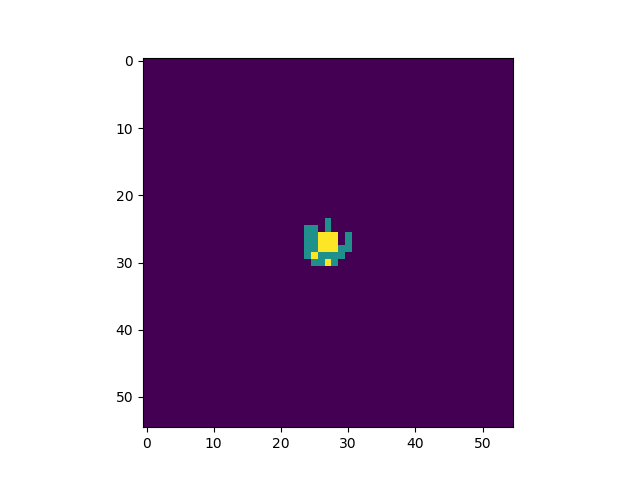

In [3]:
%matplotlib notebook

import matplotlib.pyplot as plt

f, ax = plt.subplots()

ax.imshow(results['2d']['saturation'])

# Batch mode

This system allows for very straight forward iteration over parameter space values.

## Saturation

In [4]:
import numpy as np

# Load in a calculation file, in this case the MIRI coronagraph
with open("./miri_coro_file.json") as f:
    coro_data = json.load(f)
    
# Define some variables for saturation exploration
tot_none, tot_soft, tot_hard = [], [], []
flux_range = np.linspace(0.1, 1e8, 10)
    
# Loop over some flux range to discern saturation levels
for flux in flux_range:
    # Set the flux value
    coro_data['scene'][0]['spectrum']['normalization']['norm_flux'] = flux
    
    # Perform a calculation
    results = perform_calculation(coro_data)
    
    # Store the saturation so it's easily accessible
    saturation = results['2d']['saturation']
    
    tot_none.append(len(saturation[saturation==0]))
    tot_soft.append(len(saturation[saturation==1]))
    tot_hard.append(len(saturation[saturation==2]))

<IPython.core.display.Javascript object>


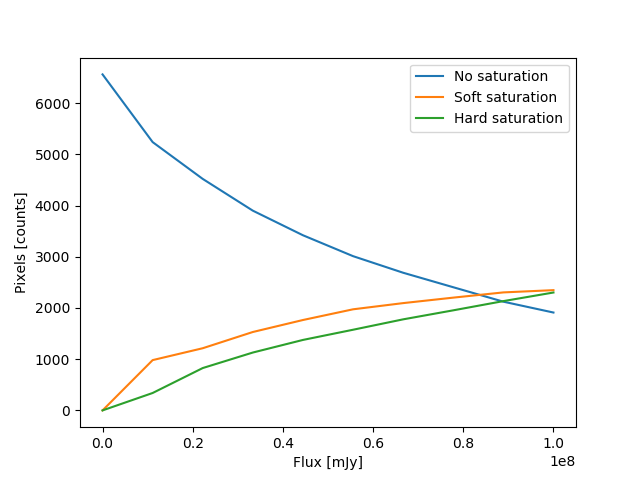

In [5]:
# Plot the values

f, ax = plt.subplots()

ax.plot(flux_range, tot_none, label="No saturation")
ax.plot(flux_range, tot_soft, label="Soft saturation")
ax.plot(flux_range, tot_hard, label="Hard saturation")

ax.set_ylabel("Pixels [counts]")
ax.set_xlabel("Flux [mJy]")
ax.legend(loc=0)

## Contrast

In [6]:
import numpy as np

# Load in a calculation file, in this case the MIRI coronagraph
with open("./miri_coro_file.json") as f:
    coro_data = json.load(f)
    
# Define some variables for saturation exploration
flux_range = np.linspace(0.1, 1.0, 10)

# Define some variables for contrast exploration
tot_cont = []
    
# Loop over some flux range to discern saturation levels
for flux in flux_range:
    # Set the flux value
    coro_data['scene'][0]['spectrum']['normalization']['norm_flux'] = flux
    
    # Perform a calculation
    results = perform_calculation(coro_data)
    
    # Get the scalar value of the contrast for the detector plane
    tot_cont.append(results['scalar']['contrast'])

<IPython.core.display.Javascript object>


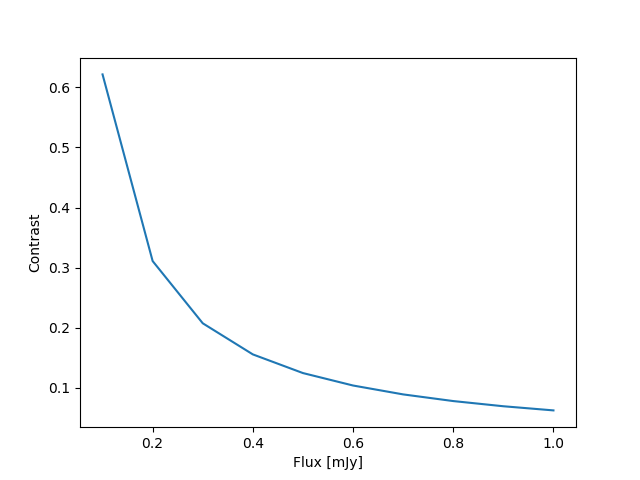

In [9]:
# Plot the values

f, ax = plt.subplots()

ax.plot(flux_range, tot_cont)

ax.set_ylabel("Contrast")
ax.set_xlabel("Flux [mJy]")